In [43]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.transforms.functional import to_tensor
import os
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import wandb
import random

In [44]:
BATCH_SIZE = 128
EPOCHS = 1000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [59]:
class BoardModel(nn.Module):
    def __init__(self):
        super(BoardModel, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64, 2),
            *[ResidualBlock(64, 64) for _ in range(1)],
            ConvBlock(64, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 256, 2),
            *[ResidualBlock(256, 256) for _ in range(3)],
            ConvBlock(256, 128, 2),
            *[ResidualBlock(128, 128) for _ in range(2)],
            ConvBlock(128, 64, 2),
            ConvBlock(64, 32, 2),
            ConvBlock(32, 1, 1, kernel_size=(4, 2)),
        )

    def forward(self, x):
        return self.layers(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        return out


In [60]:
model = BoardModel().to(DEVICE)
print(model(torch.rand(1, 3, 168, 168).to(DEVICE)).shape)

torch.Size([1, 1, 2, 4])


In [96]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.n = len([imgFile for imgFile in os.listdir(dir) if imgFile.endswith('.jpg')])

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, f"{idx}.jpg")
        img = Image.open(img_path)

        cords_path = os.path.join(self.dir, f"{idx}.txt")
        with open(cords_path, 'r') as f:
            cords = f.read().replace('[', '').replace(']', '').split(',')
        x1, y1, x2, y2, x3, y3, x4, y4 = [float(x) / 168 for x in cords]
        cords = np.array([
            [x1, y1],
            [x2, y2],
            [x3, y3],
            [x4, y4]
        ])

        if self.transform and random.random() > 0.5:
            img, cords = self.transform(img, cords)
        return to_tensor(img), torch.from_numpy(cords)

# def mirror(img, coords):
#     img_flipped, coords_flipped = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT), coords.copy()
#     coords_flipped[:, 0] = 1 - coords_flipped[:, 0]
#     return img_flipped, coords_flipped

In [97]:
model = BoardModel().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_dataset = CustomDataset(
    dir='/home/robert/Documents/GitHub/OutSmarted/data/ConnectFour/boards + cords + fields', 
    transform=None
)
print(train_dataset.n)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

4095


In [98]:
def main():
    model.train()
    for epoch in range(EPOCHS):
        for i, (img, cords) in enumerate(train_loader):
            img, cords = img.to(DEVICE), cords.to(DEVICE)
            outputs = model(img)
            loss = criterion(outputs, cords)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch: {epoch}, batch: {i}, loss: {loss.item()}")
        torch.save(model.state_dict(), f"/home/robert/Documents/GitHub/OutSmarted/data/ConnectFour/models/{epoch}.pt")
        wandb.log({"loss": loss.item()})

@torch.no_grad()
def show():
    model.eval()
    for i, (img, cords) in enumerate(train_loader):
        img, cords = img.to(DEVICE), cords.to(DEVICE)
        break
    outputs = model(img)
    img = img.cpu().numpy()
    cords = cords.cpu().numpy()
    outputs = outputs.cpu().numpy()
    for i in range(2):
        plot_image(img[i], cords[i], outputs[i])

def plot_image(image, cords, outputs):
    image = image.transpose(1, 2, 0)
    cords = cords * 168
    print(cords)
    outputs = outputs.reshape(2, 4)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image)
    ax.plot(cords[:, 0], cords[:, 1], 'ro')
    plt.show()

[[  8.27130121 148.93833876]
 [167.67144442 152.60829592]
 [159.6227088   18.5474664 ]
 [ 14.49382514  30.38664758]]


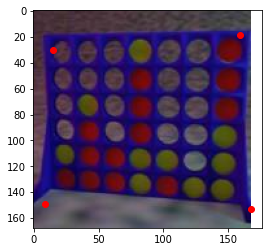

[[ 26.08690131  35.61178637]
 [138.70431948  37.49667263]
 [138.15402317 128.40812838]
 [ 26.31521094 130.55937839]]


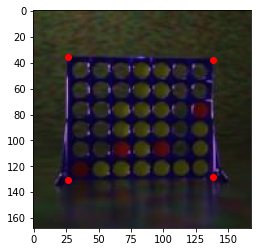

In [99]:
show()